## Constrained Bayesian Optimization with EI and UCB
In this tutorial we demonstrate the use of Xopt to perform Bayesian Optimization on a simple test problem subject to a single constraint. We will compare two acquisition functions:
1. **Expected Improvement (EI)** - balances exploitation and exploration by targeting areas with high probability of improvement
2. **Upper Confidence Bound (UCB)** - uses an explicit $\beta$ parameter to balance exploration and exploitation. **However, it requires special consideration when using with constraints**

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi], subject to a cos constraining function.

In [1]:
from xopt.evaluator import Evaluator
from xopt.generators.bayesian import (
    ExpectedImprovementGenerator,
    UpperConfidenceBoundGenerator,
)
from xopt import Xopt
from xopt.vocs import VOCS, select_best

import time
import math
import numpy as np
import matplotlib.pyplot as plt

# Ignore all warnings
import warnings

warnings.filterwarnings("ignore")

# define fixed seed
np.random.seed(42)

# define variables, function objective and constraining function
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
    constraints={"c": ["LESS_THAN", 0]},
)

C:\Users\Ryan Roussel\Documents\GitHub\Xopt\xopt\pydantic.py:39: UserWarning: Core Pydantic V1 functionality isn't compatible with Python 3.14 or greater.
  from pydantic.v1.json import custom_pydantic_encoder


In [2]:
# define a test function to optimize
def test_function(input_dict):
    return {"f": np.sin(input_dict["x"]), "c": np.cos(input_dict["x"] + 0.5)}

## Constrained Bayesian Optimization with Expected Improvement (EI)
Create the evaluator to evaluate our test function and create a generator that uses
the Expected Improvement acquisition function to perform Bayesian Optimization. Note that because we are optimizing a problem with no noise we set `use_low_noise_prior=True` in the GP model constructor.

In [3]:
evaluator = Evaluator(function=test_function)
generator_ei = ExpectedImprovementGenerator(vocs=vocs)
generator_ei.gp_constructor.use_low_noise_prior = True
X_ei = Xopt(evaluator=evaluator, generator=generator_ei, vocs=vocs)

## Generate and evaluate initial points for EI
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [4]:
# call X.random_evaluate(n_samples) to generate + evaluate initial points
X_ei.random_evaluate(n_samples=3)

# inspect the gathered data
print("Initial data for EI optimization:")
print(X_ei.data)

Initial data for EI optimization:
          x         f         c  xopt_runtime  xopt_error
0  3.929880 -0.709147 -0.278766      0.000017       False
1  0.309671  0.304745  0.689737      0.000005       False
2  1.683932  0.993607 -0.575435      0.000002       False


## Do Bayesian optimization steps with EI
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

=== Expected Improvement Optimization ===
EI Step 1


findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


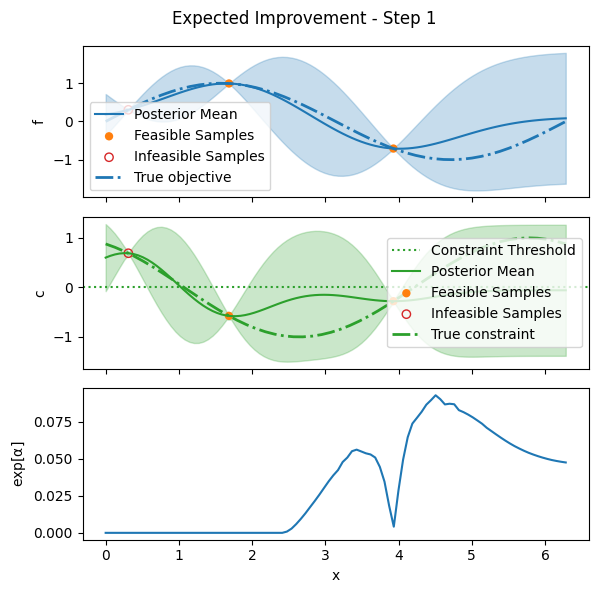

Time: 1.119s
Current best: f = -0.7091
----------------------------------------
EI Step 2


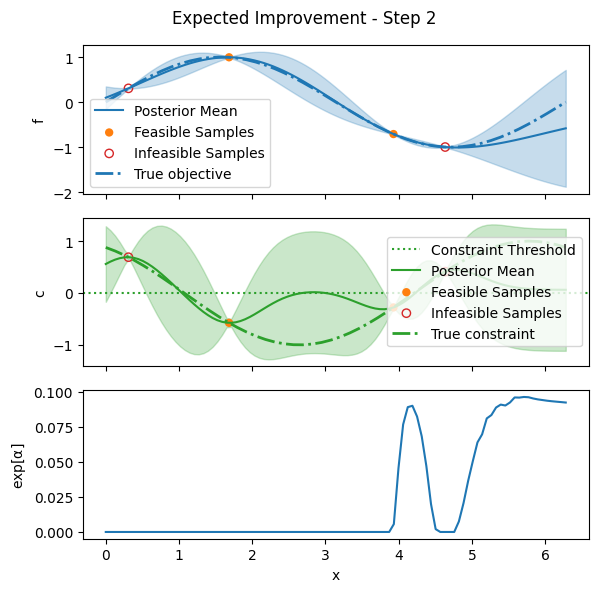

Time: 0.571s
Current best: f = -0.7091
----------------------------------------
EI Step 3


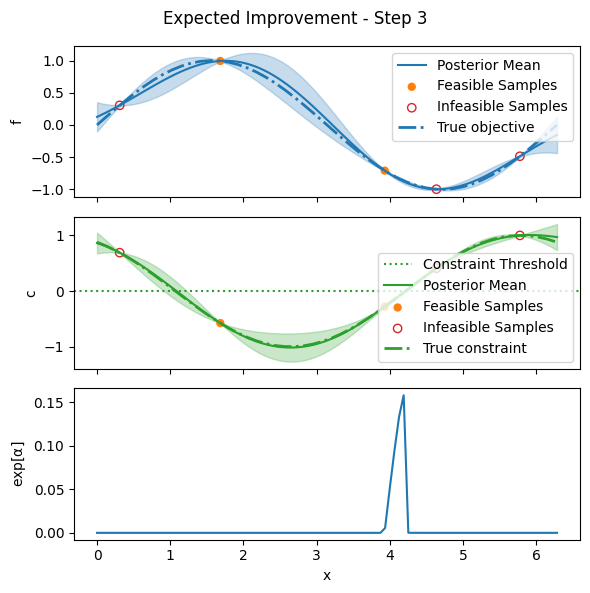

Time: 0.560s
Current best: f = -0.8628
----------------------------------------
EI Step 4


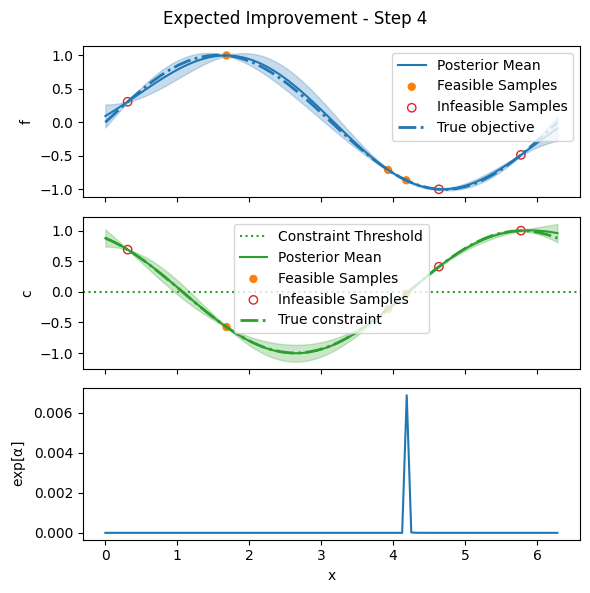

Time: 0.589s
Current best: f = -0.8736
----------------------------------------
EI Step 5


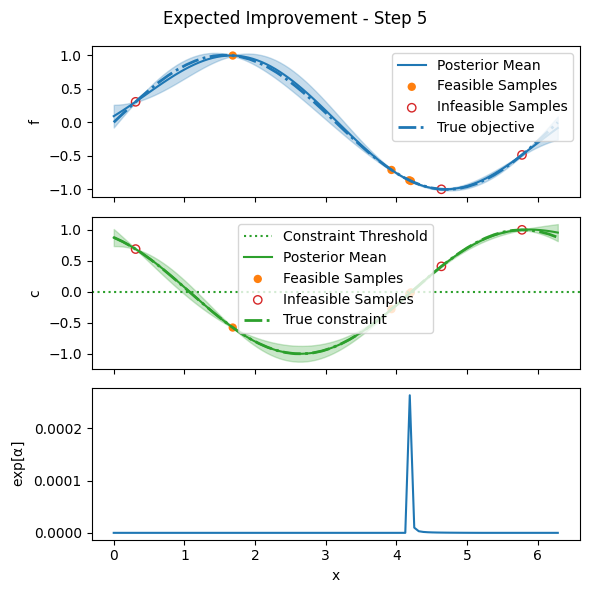

Time: 0.558s
Current best: f = -0.8757
----------------------------------------


In [5]:
n_steps = 5

# test points for plotting
test_x = np.linspace(*X_ei.vocs.bounds[0], 50)

print("=== Expected Improvement Optimization ===")
for i in range(n_steps):
    print(f"EI Step {i + 1}")
    start = time.perf_counter()

    # train model and visualize
    model = X_ei.generator.train_model()
    fig, ax = X_ei.generator.visualize_model(n_grid=100)
    fig.suptitle(f"Expected Improvement - Step {i + 1}")

    # add ground truth functions to plots
    out = test_function({"x": test_x})
    ax[0, 0].plot(test_x, out["f"], "C0-.", label="True objective", linewidth=2)
    ax[1, 0].plot(test_x, out["c"], "C2-.", label="True constraint", linewidth=2)
    ax[0, 0].legend()
    ax[1, 0].legend()

    plt.show()
    print(f"Time: {time.perf_counter() - start:.3f}s")

    # do the optimization step
    X_ei.step()
    print(f"Current best: f = {select_best(X_ei.vocs, X_ei.data)[1].item():.4f}")
    print("-" * 40)

In [7]:
# access the collected data from EI optimization
print("Final EI optimization results:")
print(X_ei.data)
print(f"EI Best valid solution: {select_best(X_ei.vocs, X_ei.data)[1].item()}")

Final EI optimization results:
          x         f         c  xopt_runtime  xopt_error
0  3.929880 -0.709147 -0.278766      0.000017       False
1  0.309671  0.304745  0.689737      0.000005       False
2  1.683932  0.993607 -0.575435      0.000002       False
3  4.636049 -0.997088  0.411099      0.000006       False
4  5.776407 -0.485363  0.999977      0.000006       False
5  4.182337 -0.862781 -0.030048      0.000006       False
6  4.204052 -0.873555 -0.008337      0.000007       False
7  4.208550 -0.875736 -0.003839      0.000006       False
EI Best valid solution: -0.8757358077717271


## Constrained Bayesian Optimization with Upper Confidence Bound (UCB)

The Upper Confidence Bound acquisition function allows a user to explicitly specify the balance between exploration and exploitation. However, for **constrained optimization**, there is an important technical requirement:

1. **Constraint handling requires positive acquisition values**: When constraints are present, the acquisition function is weighted by the probability of feasibility, **this will only work with strictly positive acquisition function values!**.
3. **The `shift` parameter ensures positivity**: Adding a positive shift ensures the UCB acquisition function is strictly positive, which is required for proper constraint weighting. Note that this addition will not change the location of the acquisition function maximum.


In [8]:
# Create UCB generator with shift parameter for constrained optimization
# The shift parameter ensures the acquisition function is strictly positive
# This is required because constrained optimization weights the acquisition
# function by the probability of feasibility: α_constrained = α_unconstrained × P(feasible)
generator_ucb = UpperConfidenceBoundGenerator(vocs=vocs, shift=2.0)
generator_ucb.gp_constructor.use_low_noise_prior = True

# Create new Xopt object for UCB
X_ucb = Xopt(evaluator=evaluator, generator=generator_ucb, vocs=vocs)

print("UCB Generator configuration:")
print(f"Shift parameter: {generator_ucb.shift}")
print("This shift ensures UCB values are strictly positive for constraint weighting")

UCB Generator configuration:
Shift parameter: 2.0
This shift ensures UCB values are strictly positive for constraint weighting


In [9]:
# Generate initial points for UCB optimization
X_ucb.random_evaluate(n_samples=3)

print("Initial data for UCB optimization:")
print(X_ucb.data)

Initial data for UCB optimization:
          x         f         c  xopt_runtime  xopt_error
0  2.521703  0.580945 -0.992822      0.000006       False
1  5.302891 -0.830661  0.886859      0.000001       False
2  5.303043 -0.830577  0.886929      0.000001       False


=== Upper Confidence Bound Optimization ===
UCB Step 1


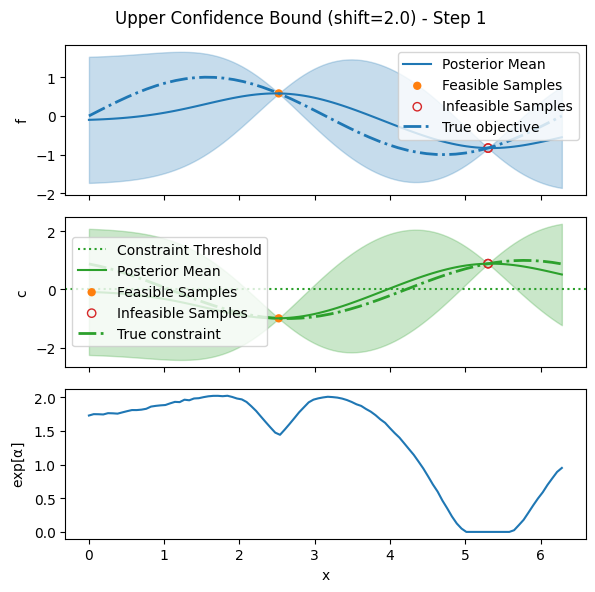

Time: 0.627s
Current best: f = 0.5809
----------------------------------------
UCB Step 2


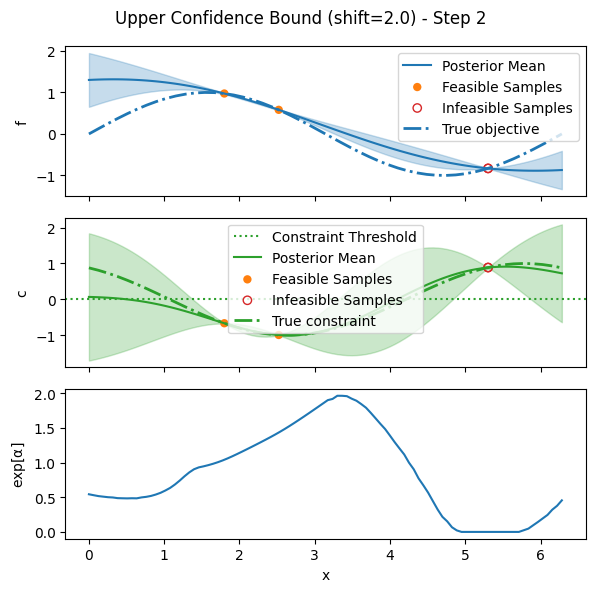

Time: 0.631s
Current best: f = -0.2498
----------------------------------------
UCB Step 3


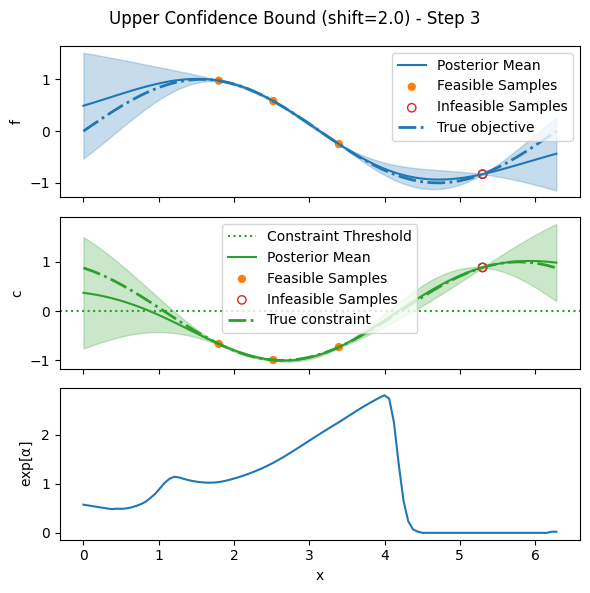

Time: 0.558s
Current best: f = -0.7643
----------------------------------------
UCB Step 4


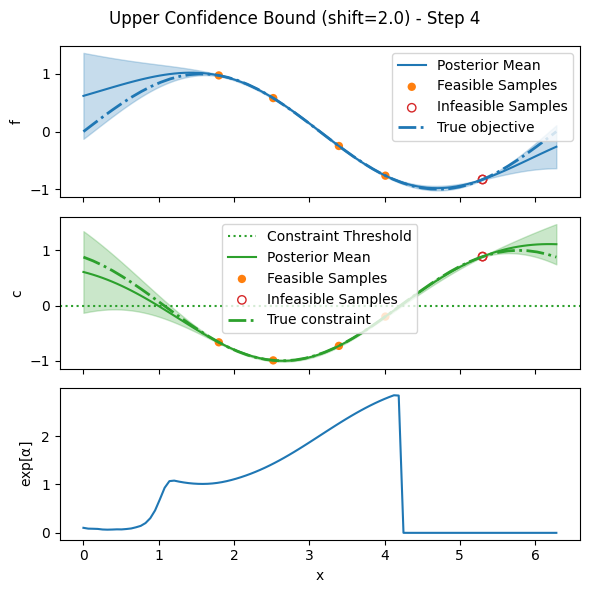

Time: 0.541s
Current best: f = -0.8625
----------------------------------------
UCB Step 5


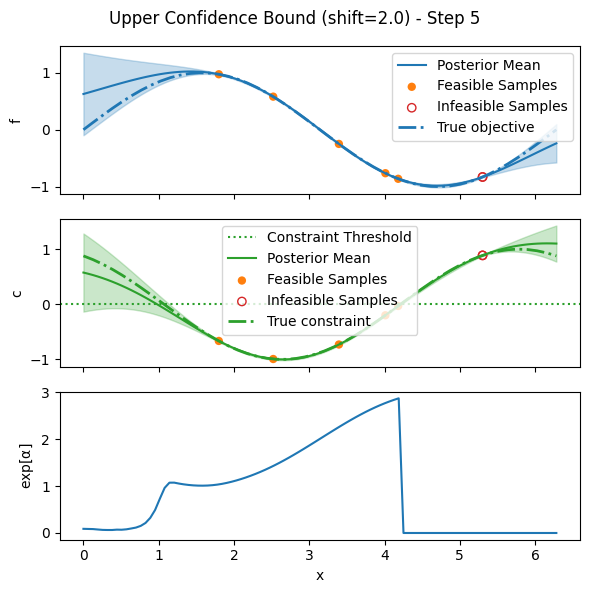

Time: 0.576s
Current best: f = -0.8670
----------------------------------------


In [10]:
print("=== Upper Confidence Bound Optimization ===")
for i in range(n_steps):
    print(f"UCB Step {i + 1}")
    start = time.perf_counter()

    # train model and visualize
    model = X_ucb.generator.train_model()
    fig, ax = X_ucb.generator.visualize_model(n_grid=100)
    fig.suptitle(f"Upper Confidence Bound (shift={generator_ucb.shift}) - Step {i + 1}")

    # add ground truth functions to plots
    out = test_function({"x": test_x})
    ax[0, 0].plot(test_x, out["f"], "C0-.", label="True objective", linewidth=2)
    ax[1, 0].plot(test_x, out["c"], "C2-.", label="True constraint", linewidth=2)
    ax[0, 0].legend()
    ax[1, 0].legend()

    plt.show()
    print(f"Time: {time.perf_counter() - start:.3f}s")

    # do the optimization step
    X_ucb.step()
    print(f"Current best: f = {select_best(X_ucb.vocs, X_ucb.data)[1].item():.4f}")
    print("-" * 40)

In [11]:
# access the collected data from UCB optimization
print("Final UCB optimization results:")
print(X_ucb.data)
print(f"UCB Best valid solution: {select_best(X_ucb.vocs, X_ucb.data)[1].item()}")

Final UCB optimization results:
          x         f         c  xopt_runtime  xopt_error
0  2.521703  0.580945 -0.992822      0.000006       False
1  5.302891 -0.830661  0.886859      0.000001       False
2  5.303043 -0.830577  0.886929      0.000001       False
3  1.798870  0.974104 -0.665433      0.000006       False
4  3.394032 -0.249767 -0.730024      0.000006       False
5  4.011605 -0.764337 -0.199438      0.000006       False
6  4.181722 -0.862470 -0.030662      0.000006       False
7  4.190746 -0.867002 -0.021641      0.000006       False
UCB Best valid solution: -0.8670015721706902


## Key Takeaways

**Expected Improvement (EI):**
- Natural balance between exploration and exploitation
- Works well out-of-the-box for both maximization and minimization
- Always positive, making it naturally compatible with constraints
- Tends to be more exploitative near the current best

**Upper Confidence Bound (UCB) for Constrained Optimization:**
- **Requires `shift` parameter for constraints**: UCB can be negative, but constrained optimization requires positive acquisition values
- **Technical requirement**: `α_constrained(x) = α_unconstrained(x) × P(feasible|x)` needs `α_unconstrained(x) > 0`
- **Shift > 0**: Ensures UCB acquisition function is strictly positive

**With Constraints:**
- Both acquisition functions handle constraints by incorporating constraint predictions
- The visualization shows both the objective model and constraint model
- Acquisition function values are weighted by probability of feasibility